In [ ]:
# default_exp vis

# Visualization
> Functions designed to visualize how the model is performing on the dataset via saliency maps.

In [ ]:
#export
import cv2
import numpy as np
import pylab as plt
import torch
from PIL import Image
from torchvision import transforms

from breakhis_gradcam.data import BreaKHisDataset, initialize_datasets
from breakhis_gradcam.resnet import resnet18
from breakhis_gradcam.utils import (
    checkpoint_state,
    get_param_lr_maps,
    setup_logging_streams,
    setup_optimizer_and_scheduler,
    train,
    validate
)

First, let's train a model for 3 epochs to have something reasonable for visualization.

In [ ]:
#example
from breakhis_gradcam.data import initialize_datasets
from breakhis_gradcam.resnet import resnet18
from torch import nn
from torchvision import transforms

def get_tta_transforms(resize_shape, normalize_transform, n=5):
    tta = transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop((resize_shape, resize_shape)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.ToTensor()
    ])
    original_transform = transforms.Compose([
        transforms.Resize((resize_shape, resize_shape)),
        transforms.ToTensor()
    ])
    return transforms.Compose([
        transforms.Lambda(
            lambda image: torch.stack(
                [tta(image) for _ in range(n)] + [original_transform(image)]
            )
        ),
        transforms.Lambda(
            lambda images: torch.stack([
                normalize_transform(image) for image in images
            ])
        ),
    ])

def get_transforms(resize_shape, tta=False, tta_n=5):
    random_resized_crop = transforms.RandomResizedCrop((resize_shape, resize_shape))
    random_horizontal_flip = transforms.RandomHorizontalFlip()
    resize = transforms.Resize((resize_shape, resize_shape))
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
    train_transforms = transforms.Compose([
        random_resized_crop, random_horizontal_flip, transforms.ToTensor(), normalize
    ])
    val_transforms = (
        get_tta_transforms(resize_shape, normalize, n=tta_n) if tta
        else transforms.Compose([resize, transforms.ToTensor(), normalize])
    )
    return train_transforms, val_transforms
    
train_transform, val_transform = get_transforms(224, tta=True)

In [ ]:
#example
ds_mapping = initialize_datasets(
    '/share/nikola/export/dt372/BreaKHis_v1/',
    label='tumor_class', criterion=['tumor_type', 'magnification'],
    split_transforms={'train': train_transform, 'val': val_transform}
)

In [ ]:
#example
tr_ds, val_ds = ds_mapping['train'], ds_mapping['val']

In [ ]:
#example
tr_dl = torch.utils.data.DataLoader(tr_ds, batch_size=32, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=32)

In [ ]:
#example
model = resnet18(pretrained=True, num_classes=2, create_log_and_save_dirs=False)
if torch.cuda.is_available():
    model = model.cuda()
mixup = True
num_epochs = 3
base_lr = 1e-3
finetune_body_factor = [1e-5, 1e-2]
param_lr_maps = get_param_lr_maps(model, base_lr, finetune_body_factor)
optimizer, scheduler = setup_optimizer_and_scheduler(param_lr_maps, base_lr, num_epochs, len(tr_dl))
criterion = {
    'train': nn.CrossEntropyLoss(reduction='none' if mixup else 'mean'),
    'val': nn.CrossEntropyLoss()
}

Setting up optimizer to fine-tune body with LR in range [0.00000001, 0.00001000] and head with LR 0.00100


In [ ]:
#example
clear_logging_handlers = setup_logging_streams(model, log_to_file=True, log_to_stdout=False)
for epoch in range(num_epochs):
    tr_loss, tr_acc = train(
        model, epoch + 1, tr_dl, criterion['train'], optimizer, scheduler=scheduler,
        mixup=mixup, alpha=0.4, logging_frequency=25
    )
    val_loss, val_acc = validate(
        model, epoch + 1, val_dl, criterion['val'], tta=True,
        logging_frequency=25
    )
    checkpoint_state(
        model, epoch + 1, optimizer, scheduler, tr_loss, tr_acc, val_loss, val_acc,
    )
clear_logging_handlers()

Now, with our trained model, let's use non-random transforms for inference, and corresponding visualization.

In [ ]:
#example
resize = transforms.Resize((224, 224))
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
inference_transform = transforms.Compose([resize, transforms.ToTensor(), normalize])
inference_ds = BreaKHisDataset.initalize(
    '/share/nikola/export/dt372/BreaKHis_v1/', label='tumor_class',
    criterion=['tumor_type', 'magnification'],
    split={'all': 1.0},
    split_transforms={'all': inference_transform}
)['all'].dataset

In [ ]:
#export
def show_image(datapoint, ax=None):
    """Shows the image corresponding to `datapoint` (taken from a `BreaKHisDataset` object).
       Optionally provide an axis object `ax` from Matplotlib for multi-image plots."""
    (fp, tumor, subtumor, magnification, slide_id, sequence_id), label = datapoint
    image = Image.open(fp)
    if ax is None:
        plt.figure()
        out_image = plt.imshow(image)
        plt.axis('off')
        ax = plt.gca()
    else:
        out_image = ax.imshow(image)
        ax.axis('off')
    if ax is None:
        plt.show()

Here's an example of what one of our images looks like.

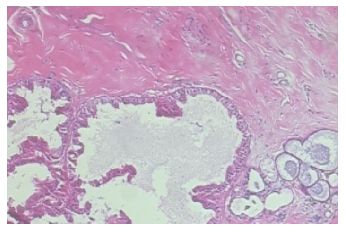

In [ ]:
#example
show_image(inference_ds[0])

In [ ]:
#export
def get_preprocessed_image(datapoint, inference_transform):
    """Returns the pre-processed image and corresponding label ID using the `inference_transform`."""
    (fp, tumor, subtumor, magnification, slide_id, sequence_id), label = datapoint
    image = Image.open(fp)
    if torch.cuda.is_available():
        return inference_transform(image).unsqueeze(0).cuda(), label
    return inference_transform(image).unsqueeze(0), label

In [ ]:
#example
get_preprocessed_image(inference_ds[0], inference_transform)

(tensor([[[[ 0.9303,  1.0331,  1.0673,  ...,  1.3242,  1.3070,  1.1700],
           [ 0.9303,  1.0502,  1.1015,  ...,  1.3242,  1.2728,  1.1358],
           [ 0.9646,  1.1187,  1.1358,  ...,  1.1872,  1.0844,  1.0844],
           ...,
           [ 0.5878,  0.7419,  0.9132,  ...,  1.4954,  1.4612,  1.3584],
           [ 0.3652,  0.3823,  0.5193,  ...,  1.4269,  1.4098,  1.3584],
           [ 0.3652,  0.4508,  0.5707,  ...,  1.3755,  1.3927,  1.3584]],
 
          [[ 0.1702,  0.1527,  0.1176,  ...,  0.5378,  0.5378,  0.5203],
           [ 0.1352,  0.1352,  0.1176,  ...,  0.5203,  0.4678,  0.5028],
           [ 0.1352,  0.1527,  0.1527,  ...,  0.3803,  0.3102,  0.4503],
           ...,
           [ 0.0301,  0.1352,  0.3627,  ...,  0.6779,  0.5903,  0.5903],
           [-0.1975, -0.2500, -0.1275,  ...,  0.5903,  0.5203,  0.5728],
           [-0.1800, -0.2150, -0.1625,  ...,  0.5378,  0.4678,  0.5553]],
 
          [[ 0.9145,  1.0365,  1.0714,  ...,  1.2980,  1.3154,  1.3328],
           [ 

In [ ]:
#export
def show_heatmap_and_original(
    model, datapoint, inference_transform, show_for_label=True, show_for_prediction=False,
    label_type='tumor_class', show_activation_grid=False
):
    """Shows a heatmap corresponding the `model`'s prediction for `datapoint` after transforming the image
       using `inference_transform`. Assumes that the model was trained on labels of `label_type`. Optionally
       show the activation grid by specifying `show_activation_grid`."""
    assert label_type in ['tumor_class', 'tumor_type'], "Please specify one of tumor class or tumor type as label type."
    assert bool(show_for_label) != bool(show_for_prediction), "Only 1 of show_for_label and show_for_prediction can be specified as True."
    (fp, tumor, subtumor, magnification, slide_id, sequence_id), label = datapoint
    x, y = get_preprocessed_image(datapoint, inference_transform=inference_transform)

    grad_dict = {}
    activation_dict = {}
    def get_activation_hooks(submodule):
        def activation_grad_hook(module, input, output):
            output_hook = None
            def output_grad_hook(grad):
                assert grad.shape == output.shape
                grad_dict[submodule] = grad.detach()
                output_hook.remove()
            output_hook = output.requires_grad_().register_hook(output_grad_hook)

        def activation_output_hook(module, input, output):
            activation_dict[submodule] = output.detach()

        return (
            getattr(model, submodule).register_forward_hook(activation_grad_hook),
            getattr(model, submodule).register_forward_hook(activation_output_hook)
        )

    activation_grad_handle, activation_output_handle = get_activation_hooks('layer4')
    try:
        model.eval()
        model.zero_grad()
        output = model(x)
        probs = torch.softmax(output, -1).cpu()
        most_confident_class = BreaKHisDataset.index_mapping[label_type][torch.argmax(probs, -1).item()]
        most_confident_prob = torch.max(probs, -1)[0].item()
        label_prob = probs[:, y].item()
        print(
            "Model would have predicted %s (%.5f vs. %.5f)" %
            (most_confident_class, most_confident_prob, label_prob)
        )
        
        if show_for_label:
            print(
                "Showing activation heatmap for the given label: %s" %
                BreaKHisDataset.index_mapping[label_type][y]
            )
            output[:, y].backward()
        else:
            print(
                "Showing activation heatmap for the model's prediction: %s" %
                BreaKHisDataset.index_mapping[label_type][torch.argmax(probs, -1).item()]
            )
            output[:, torch.argmax(probs, -1).item()].backward()
        gradients = grad_dict['layer4']
        activations = activation_dict['layer4']
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        activation_grid = (pooled_gradients.unsqueeze(0).unsqueeze(-1).unsqueeze(-1) * activations)
        activation_grid = torch.mean(activation_grid, dim=1).squeeze()
        activation_grid = np.maximum(activation_grid.detach().cpu(), 0)
        activation_grid /= torch.max(activation_grid)
        
        figsize = (25, 25)
        if show_activation_grid:
            fig, axes = plt.subplots(1, 3, figsize=figsize)
            activation_img = axes[0].matshow(activation_grid)
            fig.colorbar(activation_img, ax=axes[0], fraction=0.046, pad=0.04)
            ax_modifier = 1
        else:
            fig, axes = plt.subplots(1, 2, figsize=figsize)
            ax_modifier = 0
        
        img = np.array(Image.open(fp))
        resized_heatmap = activation_grid.numpy()
        resized_heatmap = cv2.resize(resized_heatmap, (img.shape[1], img.shape[0]))
        resized_heatmap = np.uint8(255 * resized_heatmap)
        resized_heatmap = cv2.applyColorMap(resized_heatmap, cv2.COLORMAP_JET)
        superimposed_img = resized_heatmap *0.4 + img
        assert cv2.imwrite('./map.jpg', superimposed_img)
        
        show_image(datapoint, ax=axes[ax_modifier])
        heatmap_img = axes[ax_modifier + 1].imshow(Image.open('./map.jpg'))
        fig.colorbar(heatmap_img, ax=axes[ax_modifier + 1], fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()
    finally:
        activation_grad_handle.remove()
        activation_output_handle.remove()

This is the main function for visualization. It will show an activation map using gradient-weighted activations from the last layer of the model (specifically, it's from the activations of `layer4` for every ResNet. Note that by default, the activation map is shown based on how probable the model believes the label is correct. By specifying `show_for_label` as False and `show_for_prediction` as True, one can see the activation heatmap for why the model might believe something other than the label is correct.

Below, an example is shown when the above model is visualized on a benign and malignant example.

Model would have predicted benign (0.62375 vs. 0.62375)
Showing activation heatmap for the given label: benign


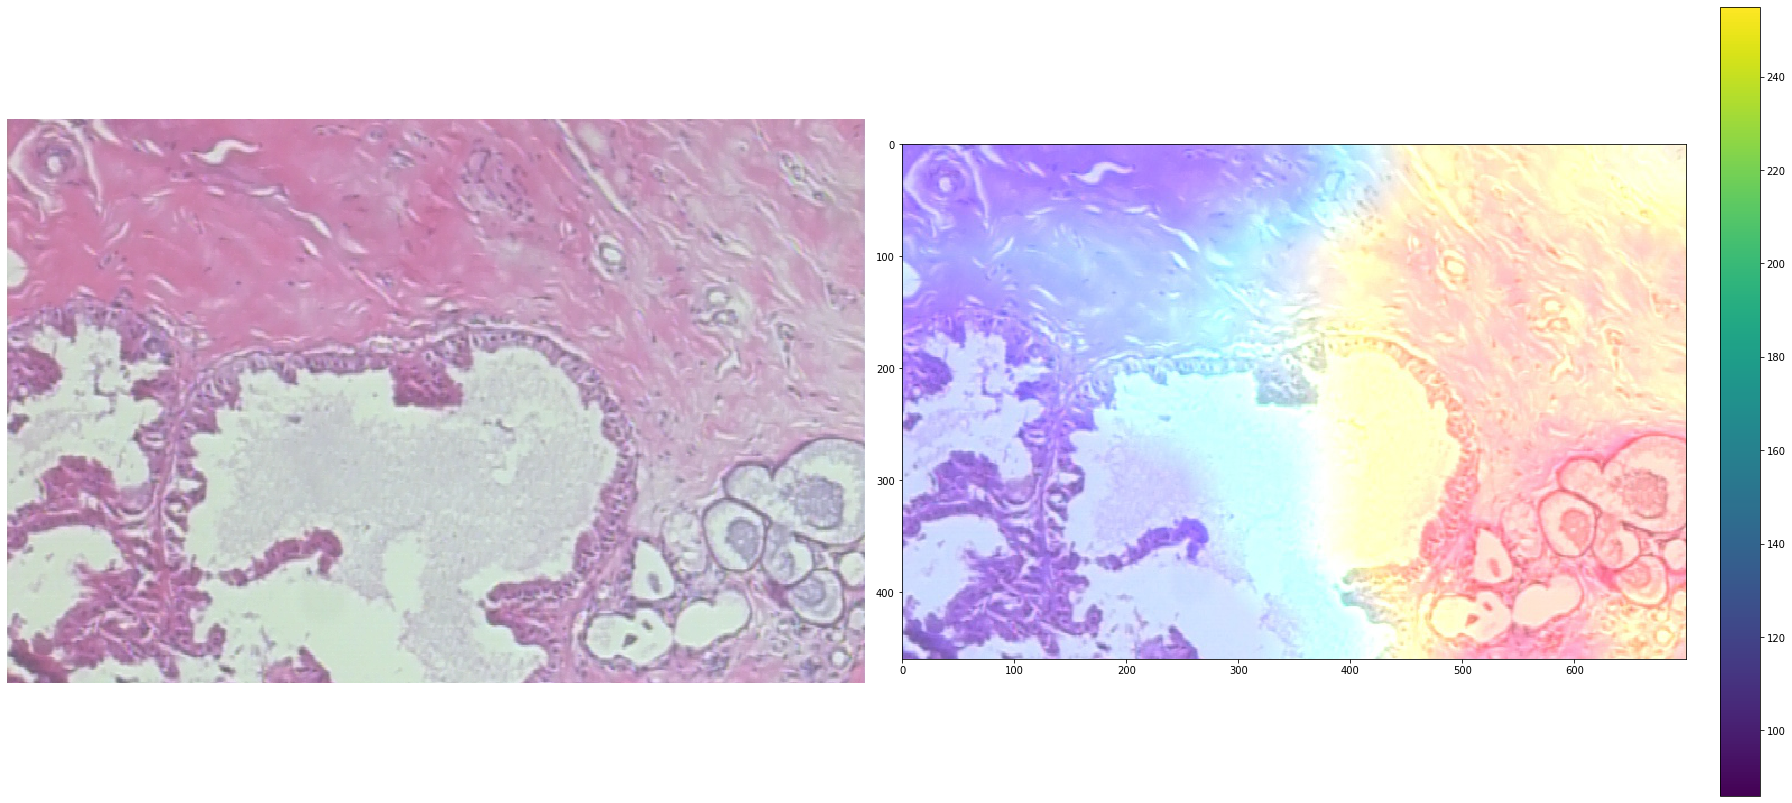

In [ ]:
#example
show_heatmap_and_original(model, inference_ds[0], inference_transform, show_activation_grid=False)

Model would have predicted benign (0.62375 vs. 0.62375)
Showing activation heatmap for the given label: benign


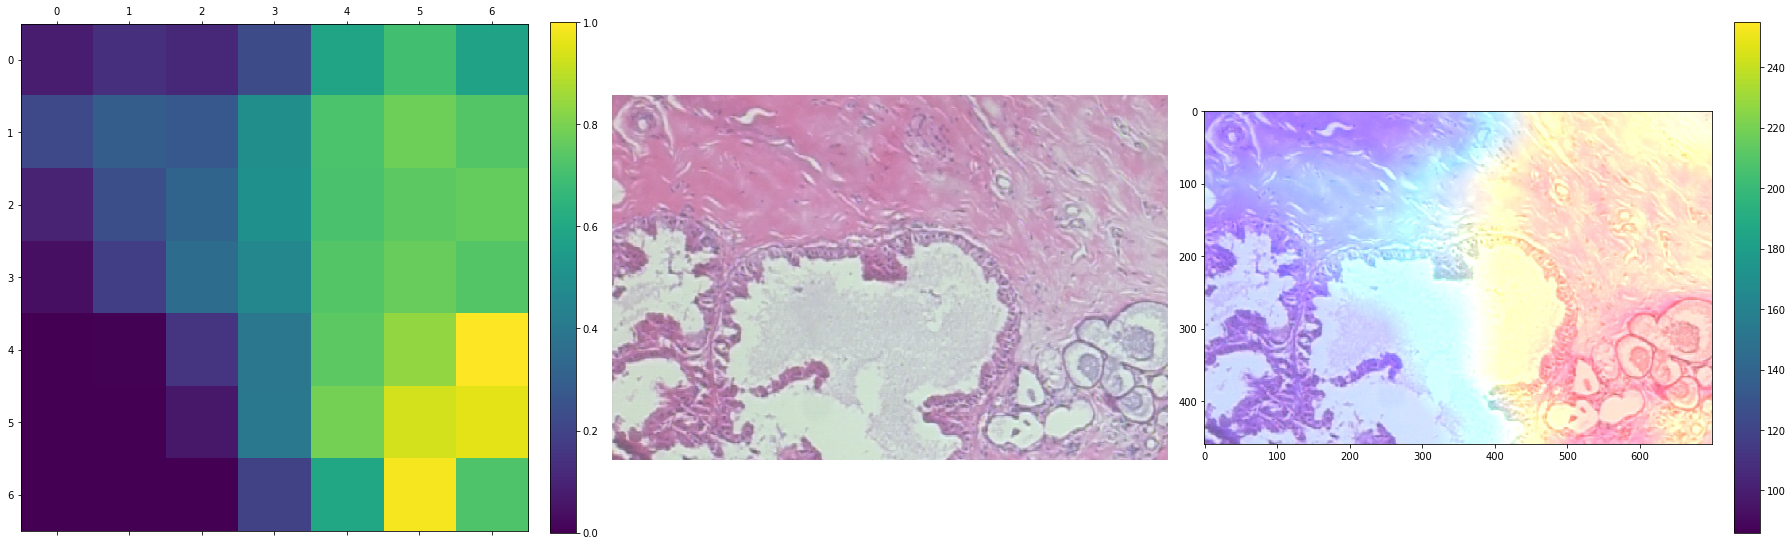

In [ ]:
#example
show_heatmap_and_original(model, inference_ds[0], inference_transform, show_activation_grid=True)

Model would have predicted malignant (0.93616 vs. 0.93616)
Showing activation heatmap for the given label: malignant


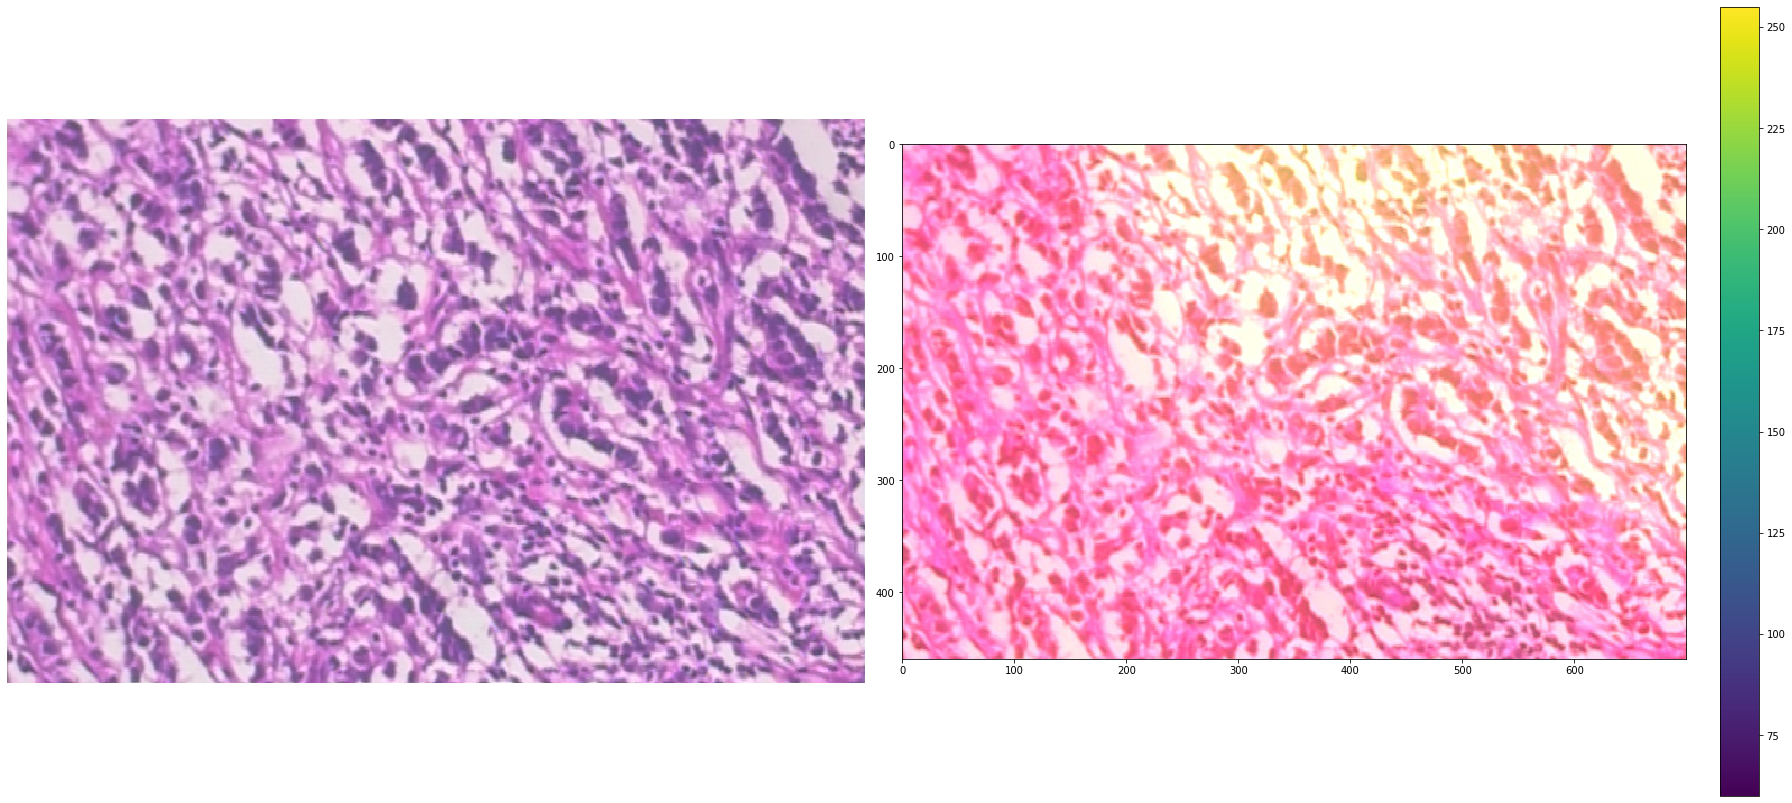

In [ ]:
#example
show_heatmap_and_original(model, inference_ds[4000], inference_transform, show_activation_grid=False)

Model would have predicted malignant (0.93616 vs. 0.93616)
Showing activation heatmap for the given label: malignant


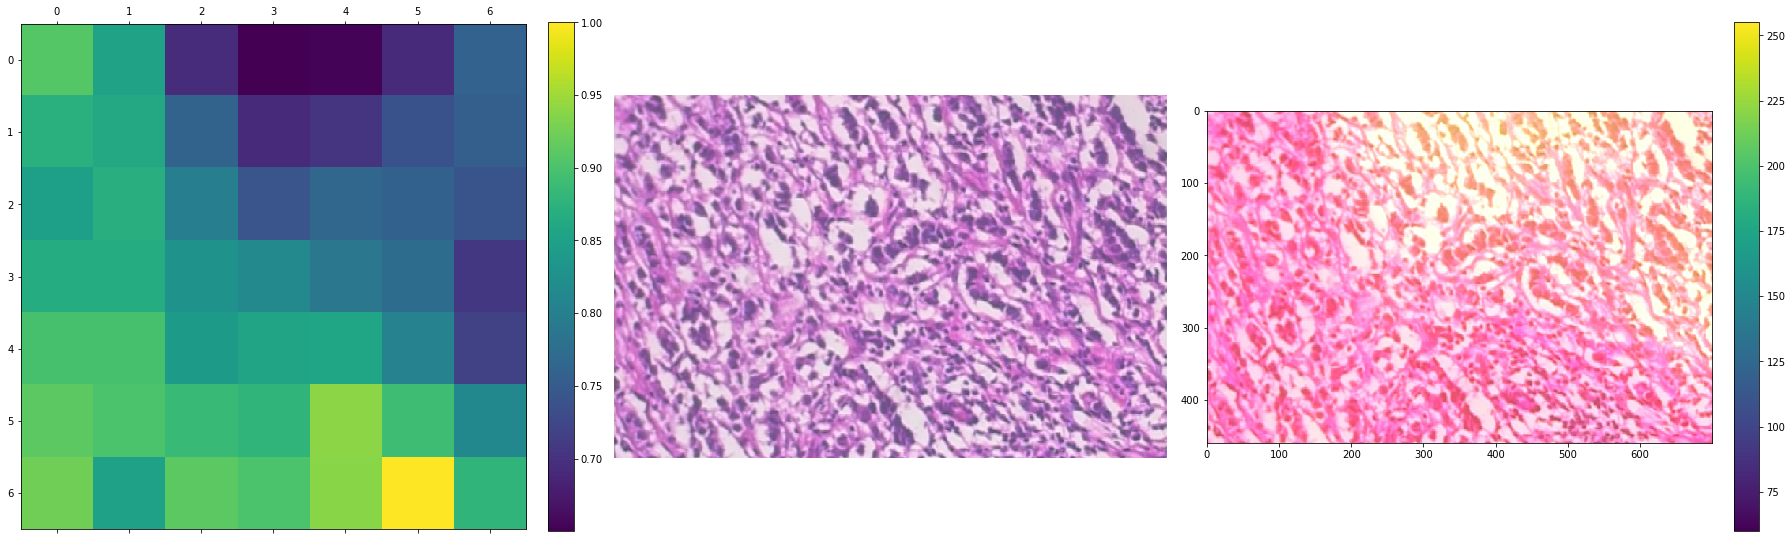

In [ ]:
#example
show_heatmap_and_original(model, inference_ds[4000], inference_transform, show_activation_grid=True)

In [ ]:
#hide
from tqdm import tqdm_notebook
model.eval()
incorrect_indices = []
for i, datapoint in tqdm_notebook(enumerate(inference_ds), total=len(inference_ds)):
    x, y = get_preprocessed_image(datapoint, inference_transform=inference_transform)
    model.zero_grad()
    output = model(x)
    most_confident_class_id = torch.argmax(output, -1).item()
    if most_confident_class_id != y:
        incorrect_indices.append(i)
        if len(incorrect_indices) == 5:
            break
print(', '.join(map(str, incorrect_indices)))

/home/dt372/anaconda2/envs/breakhis_gradcam/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


3, 30, 55, 65, 94


Here are some examples where the model was incorrect. Note how the activation heatmaps correctly piece with each other. 

Model would have predicted malignant (0.65845 vs. 0.34155)
Showing activation heatmap for the given label: benign


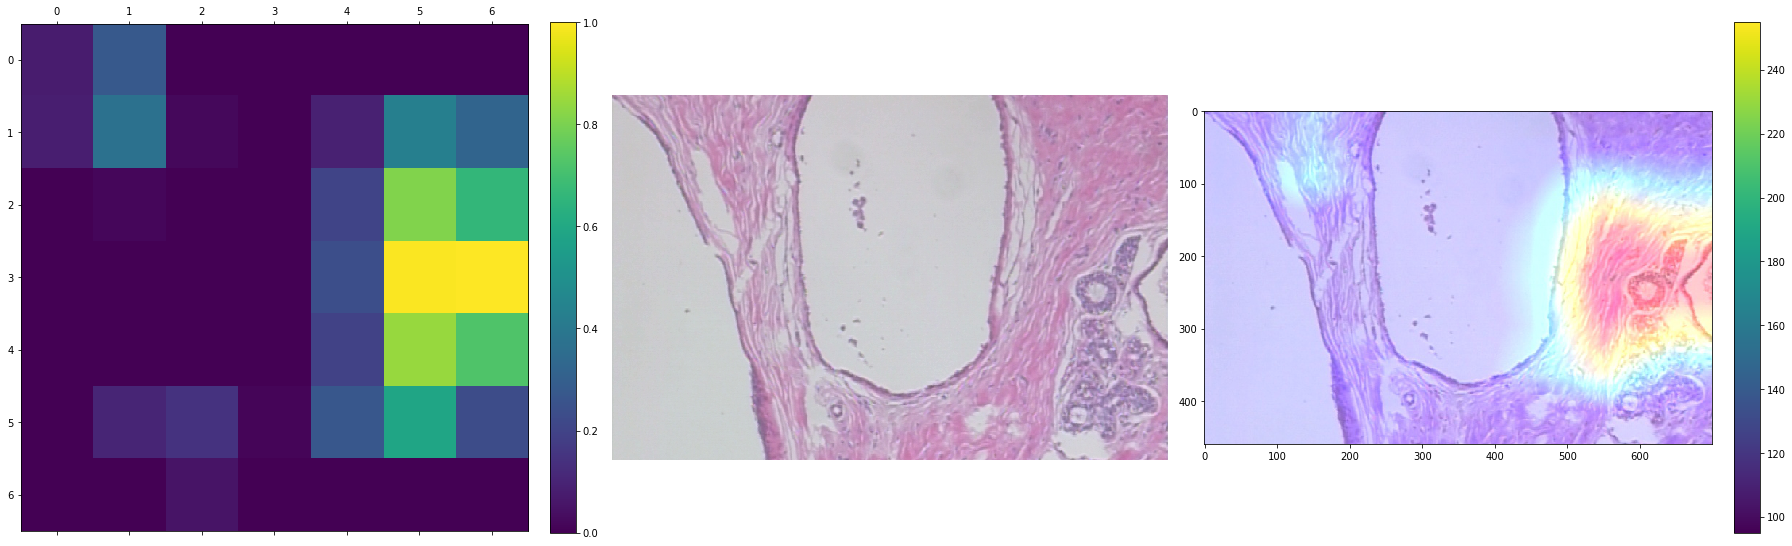

In [ ]:
#example
show_heatmap_and_original(
    model, inference_ds[3], inference_transform, show_for_label=True, show_activation_grid=True
)

Model would have predicted malignant (0.65845 vs. 0.34155)
Showing activation heatmap for the model's prediction: malignant


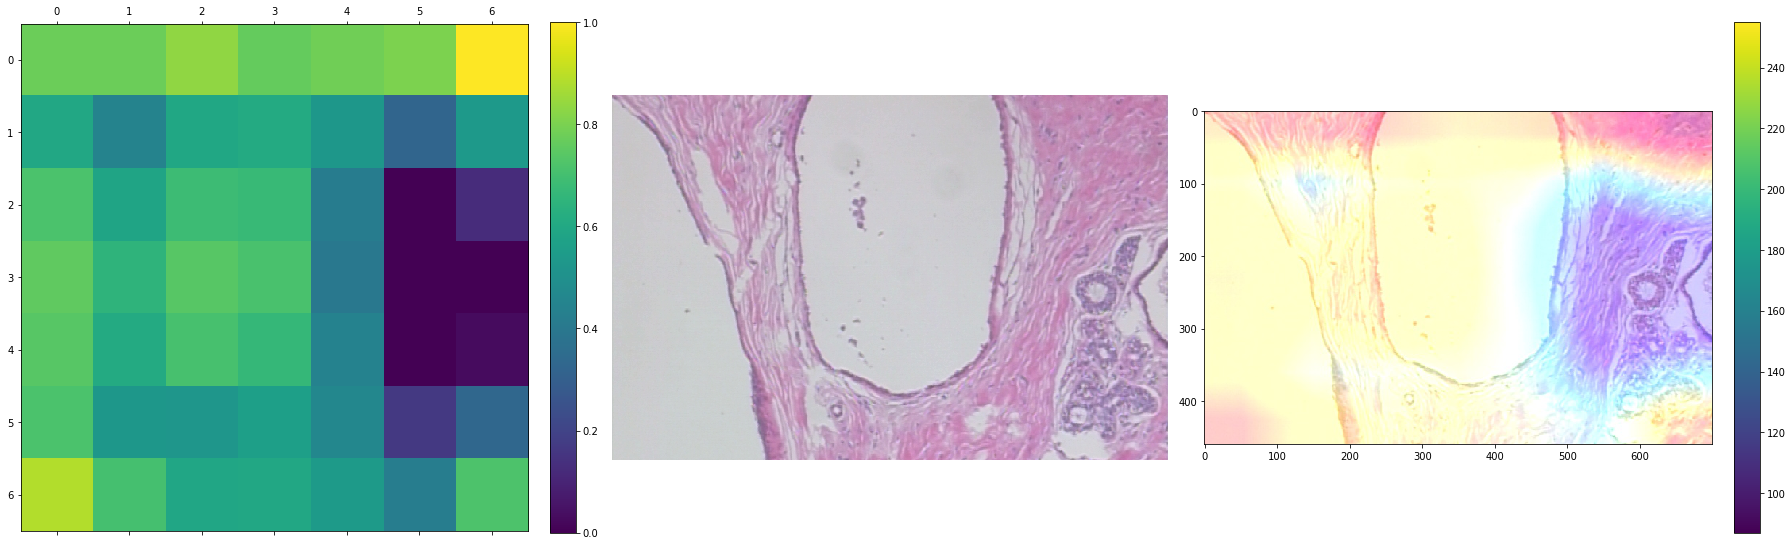

In [ ]:
#example
show_heatmap_and_original(
    model, inference_ds[3], inference_transform, show_for_label=False, show_for_prediction=True,
    show_activation_grid=True
)

Model would have predicted malignant (0.58048 vs. 0.41952)
Showing activation heatmap for the given label: benign


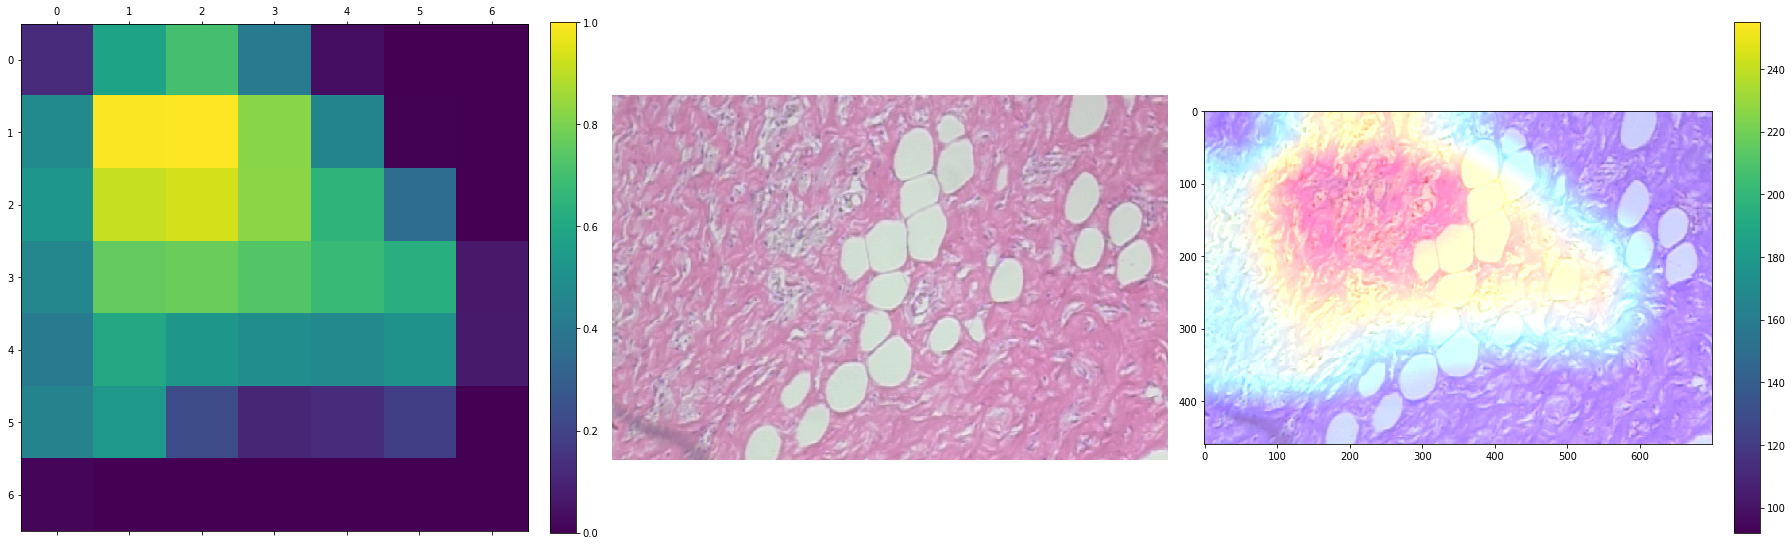

In [ ]:
#example
show_heatmap_and_original(
    model, inference_ds[30], inference_transform, show_for_label=True, show_activation_grid=True
)

Model would have predicted malignant (0.58048 vs. 0.41952)
Showing activation heatmap for the model's prediction: malignant


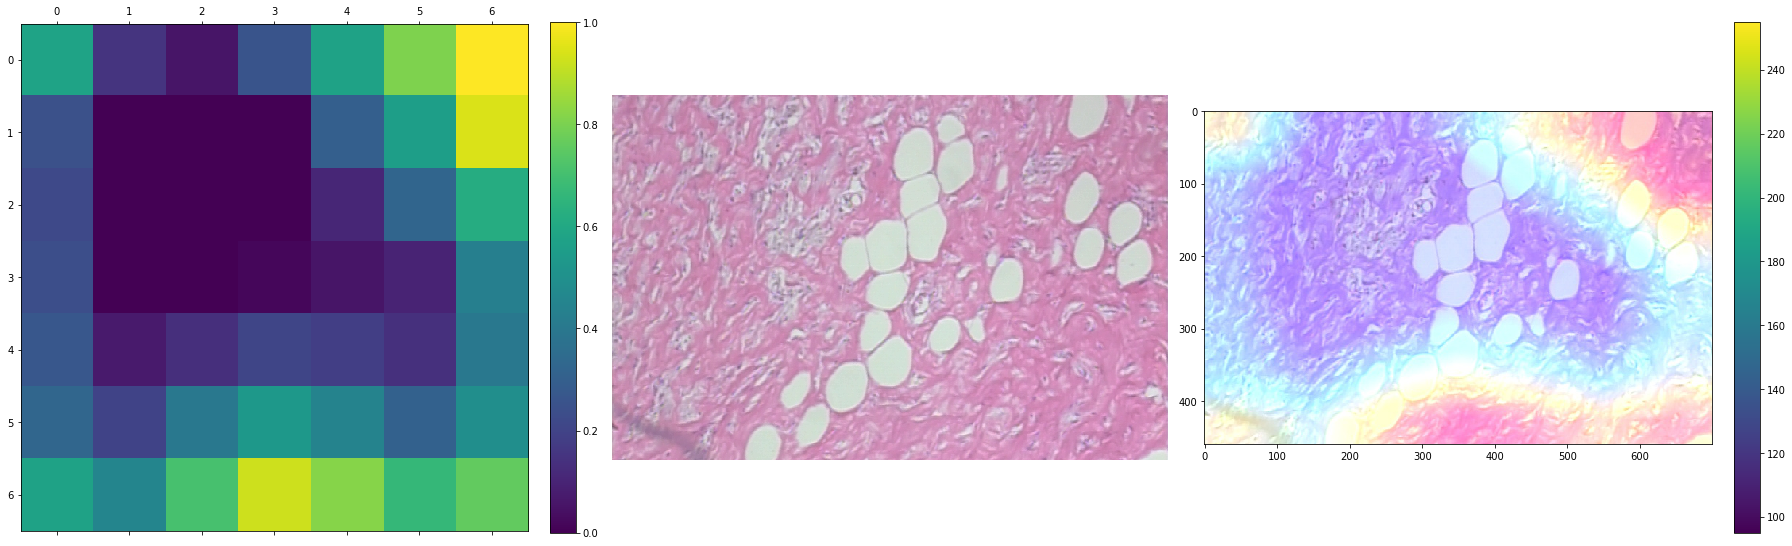

In [ ]:
#example
show_heatmap_and_original(
    model, inference_ds[30], inference_transform, show_for_label=False, show_for_prediction=True,
    show_activation_grid=True
)